In [1130]:
import importlib
import pipeline as pp
import stats_hc as hc
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

# Plots

In [1131]:
importlib.reload(hc)

data_fake_news = pd.read_csv("../datasets/sample/cols_and_rows_removed_combined.csv")

Fake_News_Corpus = hc.Fake_News_Corpus(data=data_fake_news, content_label="content_cleaned", type_label="type", binary_type_label='type_binary', domain_label='domain', sentence_analysis_label="sentence_no_swords_analysis")

Stat_Fake_News_Corpus = hc.Statistics_Fake_News_Corpus(fake_news=Fake_News_Corpus)

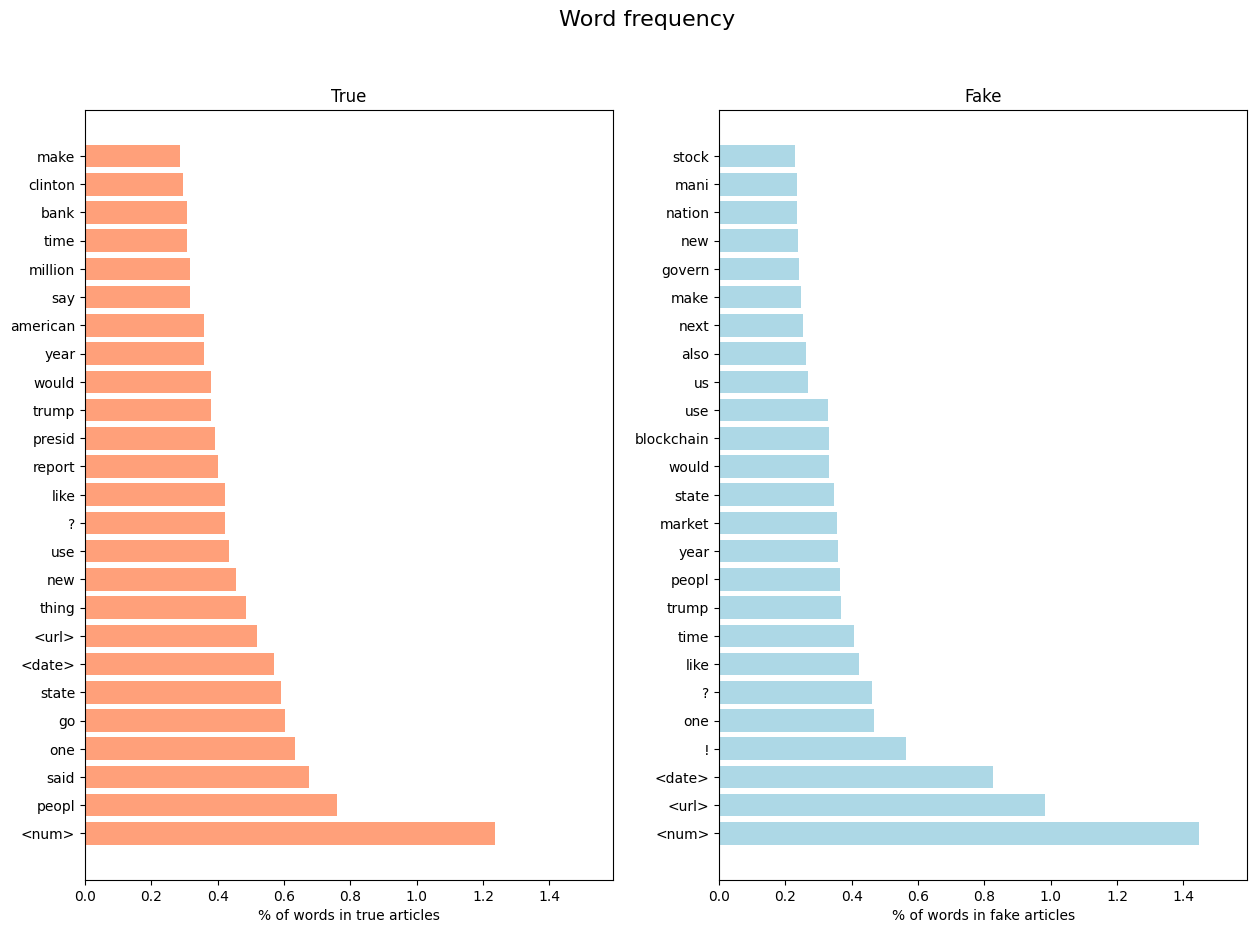

In [1132]:
Stat_Fake_News_Corpus.barplot_word_frequency()

In [1133]:
Stat_Fake_News_Corpus.word_frequency()


True:
count      27.000000
mean      350.666667
std       380.433862
min        12.000000
25%       133.500000
50%       226.000000
75%       376.500000
max      1722.000000
Name: content_cleaned, dtype: float64

Fake:
count     205.000000
mean      381.292683
std       394.197860
min         9.000000
25%       109.000000
50%       278.000000
75%       513.000000
max      2656.000000
Name: content_cleaned, dtype: float64


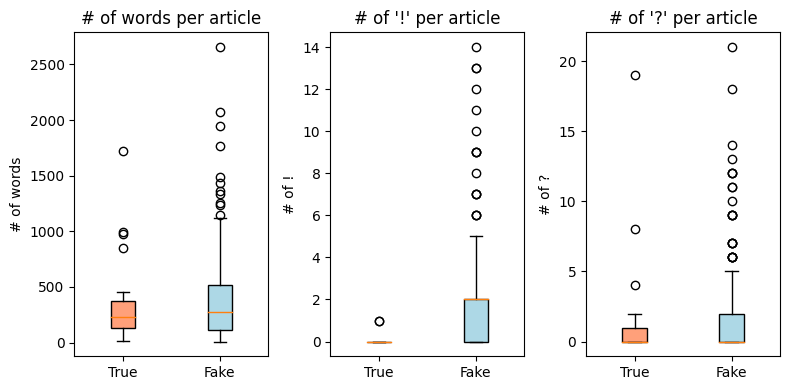

In [1134]:
Stat_Fake_News_Corpus.boxplot_word_frequency()

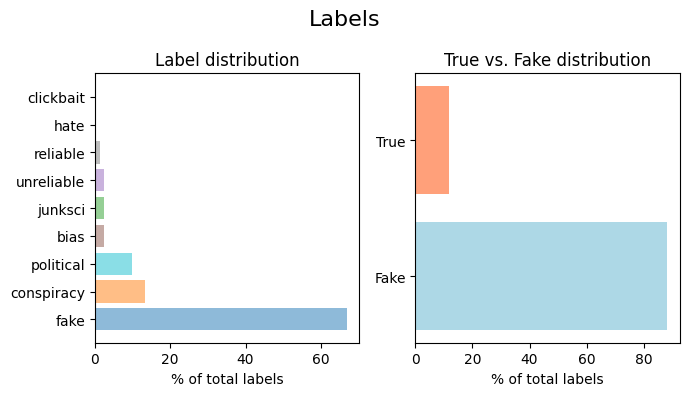

In [1135]:
Stat_Fake_News_Corpus.plot_type()

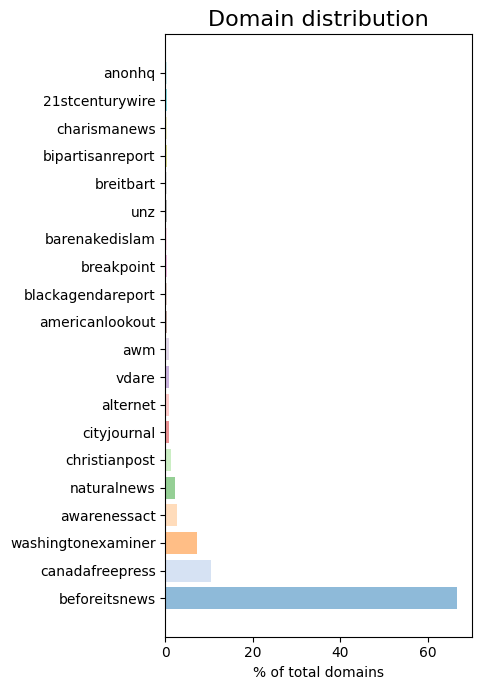

In [1136]:
Stat_Fake_News_Corpus.barplot_domain(num=20)

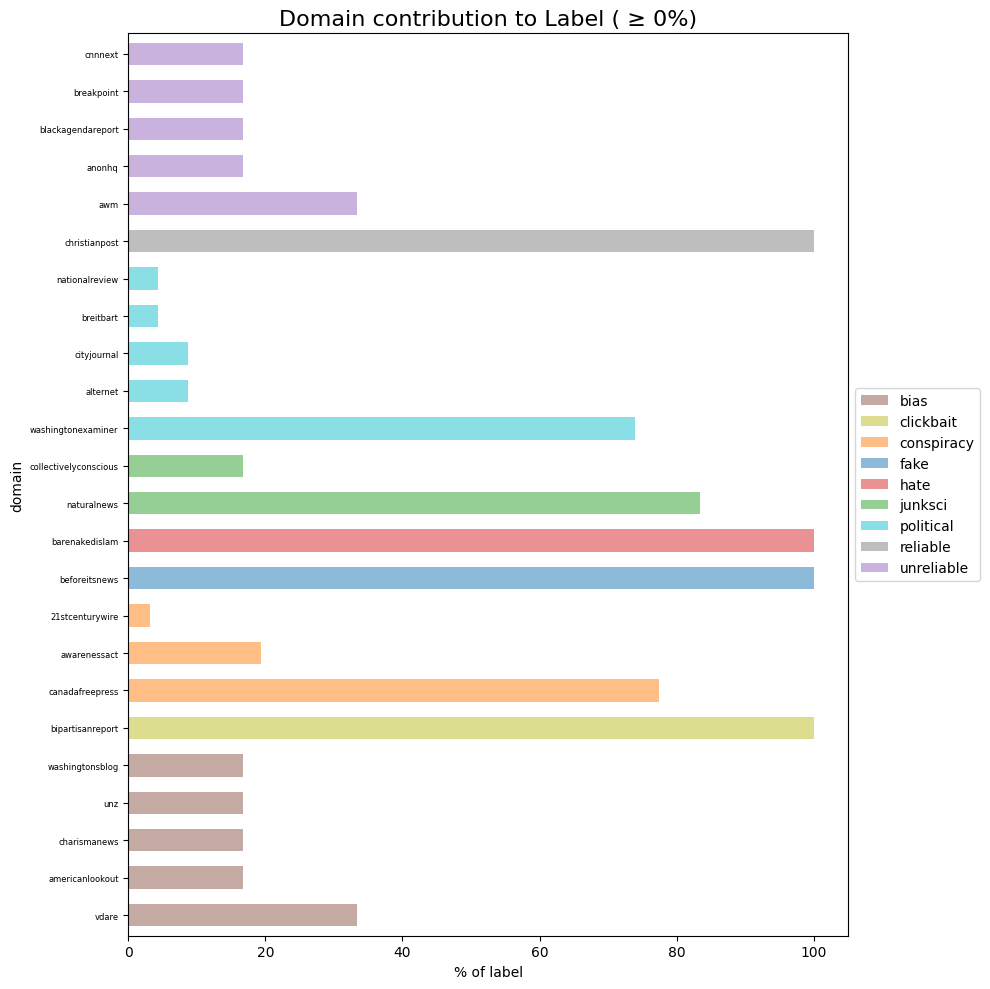

In [1137]:
threshold=0
percentage=True
Stat_Fake_News_Corpus.barplot_domain_to_label_contribution(threshold=threshold, percentage=percentage)

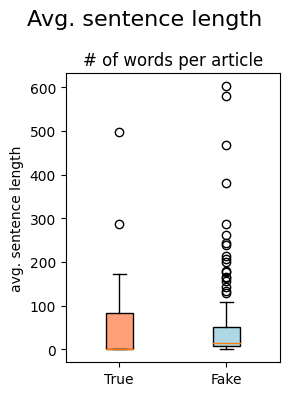

In [1138]:
Stat_Fake_News_Corpus.plot_average_sentence_length()

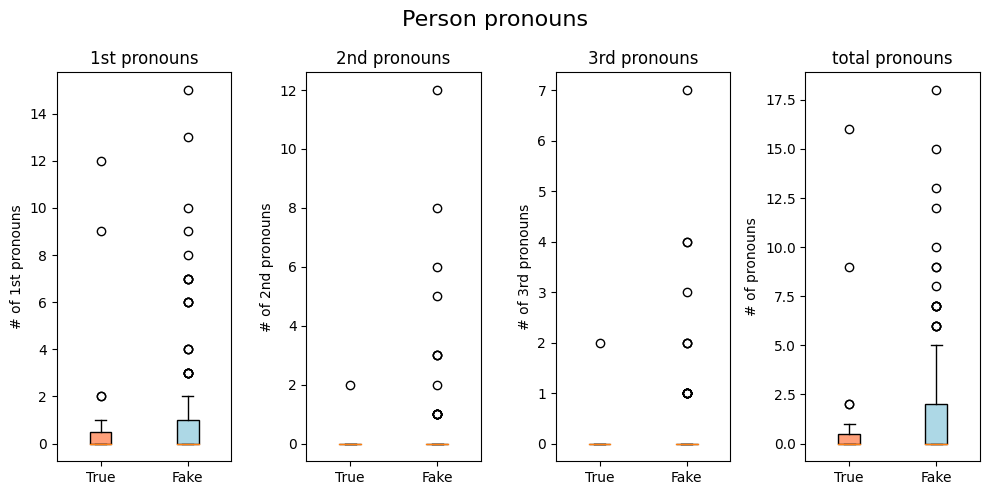

In [1139]:
Stat_Fake_News_Corpus.plot_pronouns()

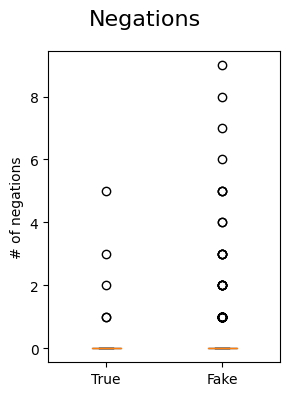

In [1140]:
Stat_Fake_News_Corpus.plot_negations()

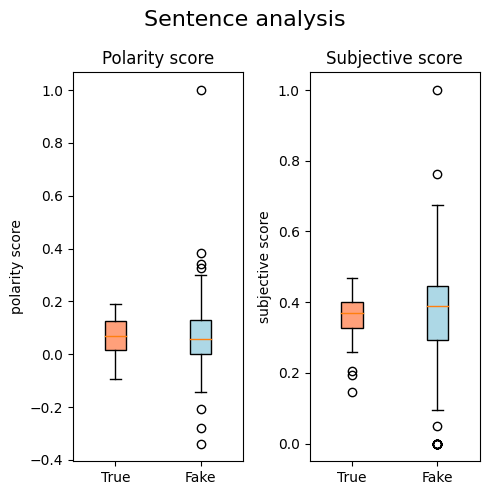

In [1141]:
Stat_Fake_News_Corpus.plot_sentence_analysis()

# Liar

In [1142]:
importlib.reload(hc)

data_liar = pd.read_csv("../datasets/liar_dataset/cleaned/combined_cleaned.csv")

Liar = hc.Liar(data=data_liar, type_label="label", binary_type_label='label_binary', statement_label="statement_cleaned", subjects_label='subjects', speaker_label='speaker', party_label='party', sentence_analysis_label="sentence_analysis")

# Fake News Corpus vs. Liar

In [1143]:
importlib.reload(hc)
Fake_vs_liar = hc.Statistics_Fake_News_vs_Liar(fake_news=Fake_News_Corpus, liar=Liar)

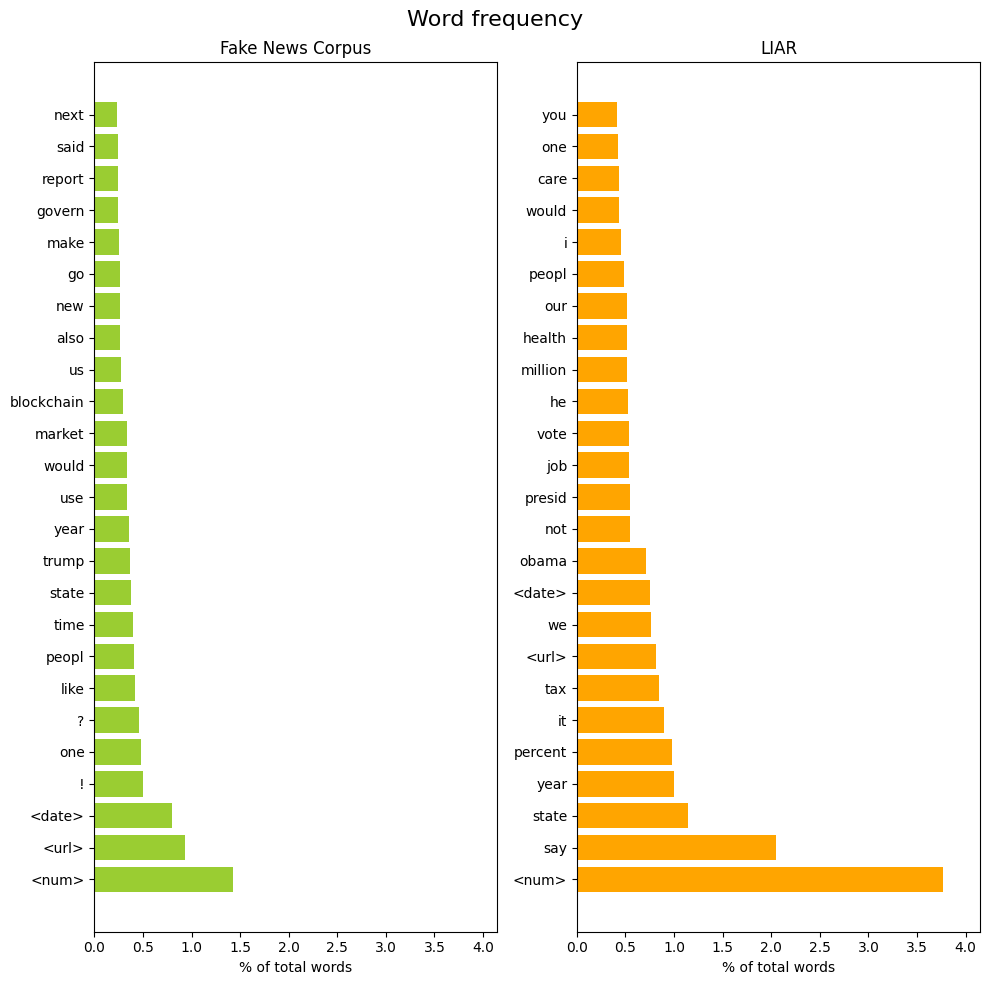

In [1144]:
Fake_vs_liar.barplot_word_frequency()

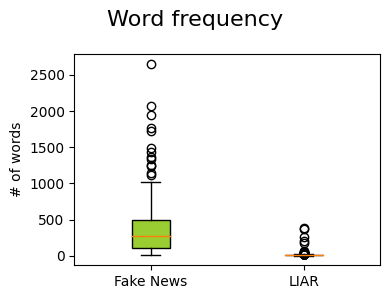

In [1145]:
Fake_vs_liar.boxplot_word_frequency()

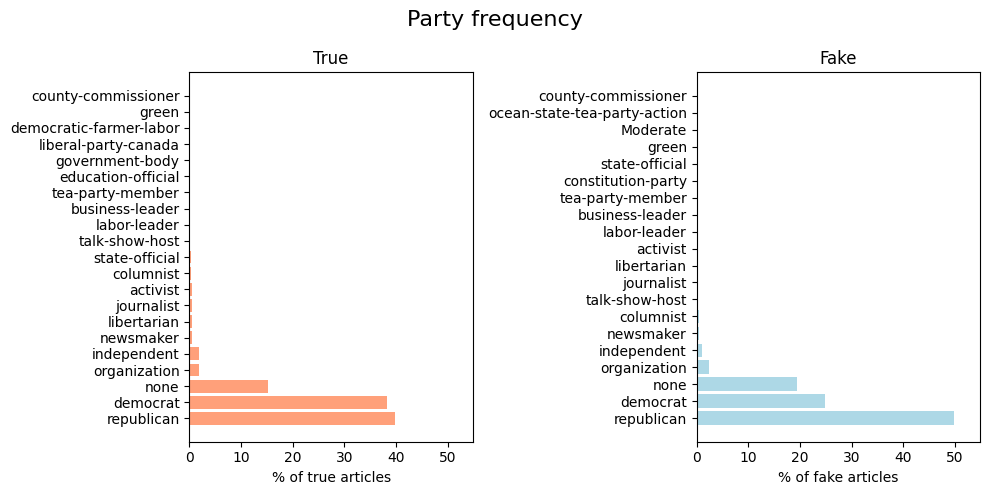

In [1146]:
Fake_vs_liar.plot_party()

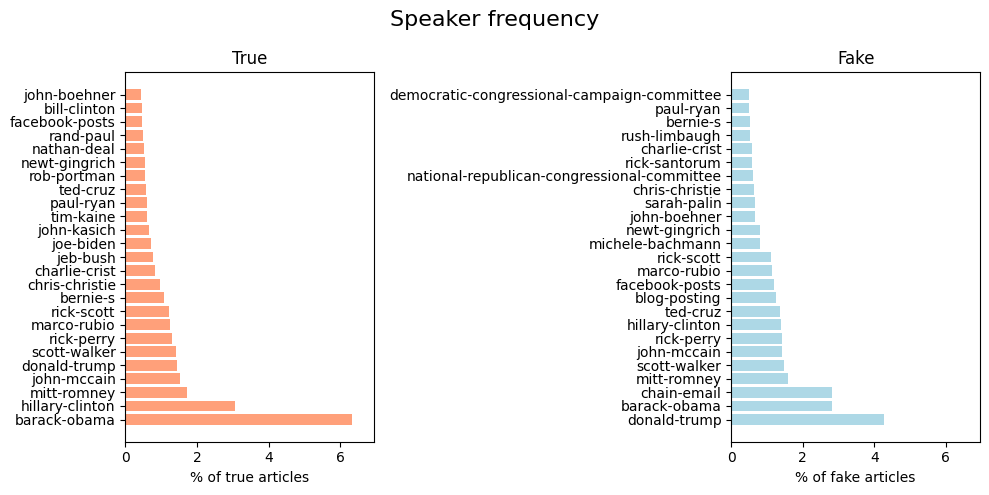

In [1147]:
Fake_vs_liar.plot_speaker()

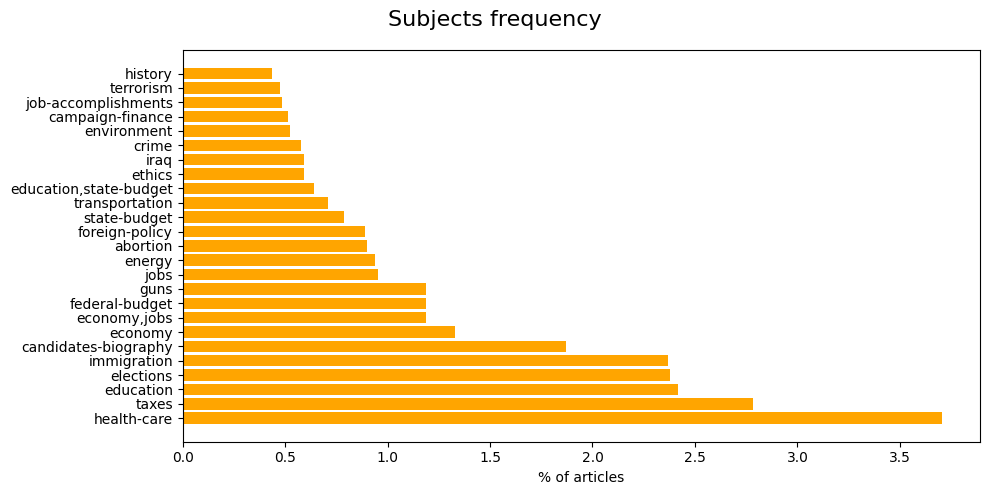

In [1148]:
Fake_vs_liar.plot_subjects()

# KMeans Clustering

The KMeans clustering algorithm uses the TF-IDF (Term Frequency-Inverse Document Frequency) matrix as input to cluster the documents into k clusters. The TF-IDF matrix represents each document as a vector of term frequencies, normalized by their inverse document frequency across the corpus.

The KMeans algorithm then iteratively assigns each document to a cluster and updates the cluster centroids until convergence. The assignment is based on the similarity between the document vector and the centroid of each cluster. The similarity metric used is the Euclidean distance between the document vector and the centroid vector in the TF-IDF space.

In addition to the TF-IDF matrix, the KMeans algorithm takes several parameters, including the number of clusters (k), the initialization method (e.g., k-means++), the maximum number of iterations, and the number of times the algorithm will be run with different random initializations.

In [1149]:
# Vectorize the corpus using TF-IDF
# Convert non-string values to string
content_cleaned_str = data['content_cleaned'].apply(lambda x: str(x))
# Vectorize the corpus using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(content_cleaned_str)

NameError: name 'data' is not defined

### Plot the elbow curve to determine the optimal number of clusters.

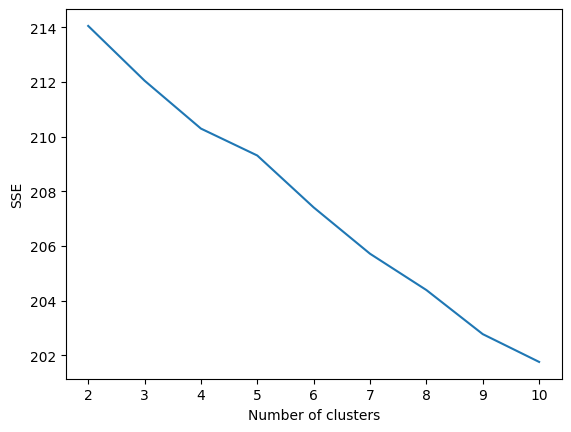

In [ ]:
# Calculate SSE for different values of k
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tfidf)
    sse[k] = kmeans.inertia_ 

# Plot SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Perform clustering using the result from the elbow curve.

In [ ]:
# Perform K-Means clustering
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(tfidf)

# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster 0 terms: day, christ, lord, easili, understand, differ, end, time, flagship, flagshipgav, 
Cluster 1 terms: feel, cancer, url, blockchain, think, link, stori, long, life, like, 
Cluster 2 terms: num, peopl, like, mani, url, error, food, domain, anon, help, 
Cluster 3 terms: terrorist, trump, obama, isi, presid, url, video, meet, administr, deal, 
Cluster 4 terms: obama, govern, clinton, presid, state, russia, num, russian, url, trump, 
Cluster 5 terms: num, date, market, url, bank, year, blockchain, time, global, new, 


In [ ]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf.toarray(), kmeans.labels_, metric='euclidean', n_jobs=-1)

# Print silhouette score
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.04224988223595737


### Plot the clusters using a a scatterplot in 2d with PCA.

C:\Users\henri\AppData\Local\Temp\ipykernel_108460\3790092383.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1],


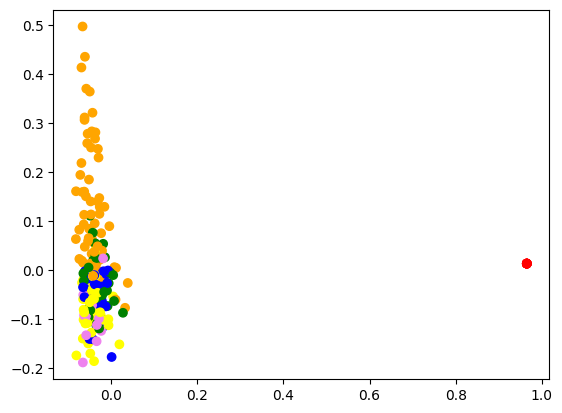

In [ ]:
# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}
colors = [label_to_color[label] for label in kmeans.labels_]

# Visualize the clusters
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], 
            c=colors, 
            cmap='rainbow',
            )
plt.show()

In [ ]:
kmeans.labels_

array([2, 0, 2, 4, 4, 4, 5, 2, 3, 5, 5, 5, 5, 4, 1, 3, 4, 2, 3, 5, 1, 5,
       4, 2, 5, 4, 5, 5, 2, 5, 5, 5, 1, 5, 5, 4, 4, 4, 0, 5, 4, 3, 0, 1,
       4, 5, 2, 5, 5, 2, 0, 4, 2, 5, 2, 5, 2, 3, 1, 5, 5, 4, 5, 5, 4, 5,
       1, 5, 1, 2, 4, 5, 5, 5, 4, 2, 5, 5, 4, 5, 2, 5, 1, 1, 2, 2, 1, 2,
       3, 4, 2, 5, 5, 1, 0, 4, 1, 4, 2, 5, 5, 5, 1, 1, 1, 5, 4, 3, 5, 1,
       2, 4, 2, 4, 4, 5, 2, 4, 3, 4, 5, 5, 4, 2, 1, 2, 5, 5, 3, 4, 0, 1,
       4, 4, 5, 2, 1, 3, 4, 1, 1, 1, 5, 5, 1, 2, 5, 4, 3, 2, 1, 5, 5, 5,
       5, 5, 4, 4, 1, 4, 1, 3, 2, 2, 2, 1, 4, 1, 2, 2, 0, 2, 2, 2, 5, 5,
       1, 3, 5, 5, 0, 2, 4, 3, 4, 2, 3, 5, 5, 4, 0, 1, 5, 1, 1, 2, 2, 2,
       5, 2, 1, 2, 5, 3, 5, 4, 4, 4, 4, 2, 4, 1, 4, 4, 5, 5, 3, 5, 2, 4,
       2, 3, 4, 4, 5, 4, 5, 3, 5, 5, 5, 5])

In [ ]:
label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}

In [ ]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster red terms: day, christ, lord, easili, understand, differ, end, time, flagship, flagshipgav, 
Cluster blue terms: feel, cancer, url, blockchain, think, link, stori, long, life, like, 
Cluster green terms: num, peopl, like, mani, url, error, food, domain, anon, help, 
Cluster violet terms: terrorist, trump, obama, isi, presid, url, video, meet, administr, deal, 
Cluster yellow terms: obama, govern, clinton, presid, state, russia, num, russian, url, trump, 
Cluster orange terms: num, date, market, url, bank, year, blockchain, time, global, new, 


In [ ]:
# add the list with the cluster labels to the dataframe
# modify the cluster label to be a string with the color of the cluster plus the word cluster in front
data['cluster'] = kmeans.labels_
# add the cluster label to the content

# concat the cluster label to the content

# create a new column 'cluster_color' that maps cluster labels to color codes
data['cluster_color'] = data['cluster'].map(label_to_color)

# create a new column 'cluster_string' that concatenates the color code and cluster label string
data['cluster_string'] = data['cluster_color'] + 'Cluster'

data['content_with_cluster'] = data['content'] + ' ' + data['cluster_string'].astype(str)

data['content'] = data['content'].apply(lambda x: x + " " + str(kmeans.labels_))

In [ ]:

cluster_top_terms = {}

for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
        # build a dict with the top 10 terms for each cluster
        cluster_top_terms[i] = [terms[j] for j in order_centroids[i, :10]]
    print()

for cluster_label in cluster_top_terms.keys():
    # get the rows corresponding to the current cluster label
    cluster_rows = data[data['cluster'] == cluster_label]
    
    # join the top terms for the current cluster as a string
    top_terms_str = ' '.join(cluster_top_terms[cluster_label])
    
    # add the top terms to the content_with_cluster column for the current cluster rows
    data.loc[cluster_rows.index, 'content_with_cluster'] += ' ' + top_terms_str

# data.to_csv('../datasets/big/dataset_unbalanced_cleaned_cluster.csv', index=False)
data.iloc[0]['content_with_cluster']


Cluster red terms: day, christ, lord, easili, understand, differ, end, time, flagship, flagshipgav, 
Cluster blue terms: feel, cancer, url, blockchain, think, link, stori, long, life, like, 
Cluster green terms: num, peopl, like, mani, url, error, food, domain, anon, help, 
Cluster violet terms: terrorist, trump, obama, isi, presid, url, video, meet, administr, deal, 
Cluster yellow terms: obama, govern, clinton, presid, state, russia, num, russian, url, trump, 
Cluster orange terms: num, date, market, url, bank, year, blockchain, time, global, new, 


'During the ceremony to mark the 72nd anniversary of the Hiroshima anniversary Japan’s Prime Minister made an effort to call for world peace. According to Shinzo Abe Japan will be doing all it can to work towards eternal world peace.\r\n\r\nAs you may know, Japan has undergone two atomic bombs both dropped by the US. The first on Hiroshima and the second just a few days later in Nagasaki; the atomic bomb on Hiroshima detonated around 600 meters above the city and killed over 140,000. While it did effectively end the Second World War it was a huge price that Japan is never willing to pay again.\r\n\r\nSadly, the commemoration was overshadowed by the threat that has been posed by North Korea. Last month, the North Korean military tested two intercontinental ballistic missiles with major US cities like Chicago within the range of attack. According to the Japan Times, around 50,000 people attended the ceremony and that included representatives from 80 nations.\r\n\r\nIf any kind of nuclear

In [ ]:
kmeans.labels_
data.iloc[0]['content_with_cluster']

'During the ceremony to mark the 72nd anniversary of the Hiroshima anniversary Japan’s Prime Minister made an effort to call for world peace. According to Shinzo Abe Japan will be doing all it can to work towards eternal world peace.\r\n\r\nAs you may know, Japan has undergone two atomic bombs both dropped by the US. The first on Hiroshima and the second just a few days later in Nagasaki; the atomic bomb on Hiroshima detonated around 600 meters above the city and killed over 140,000. While it did effectively end the Second World War it was a huge price that Japan is never willing to pay again.\r\n\r\nSadly, the commemoration was overshadowed by the threat that has been posed by North Korea. Last month, the North Korean military tested two intercontinental ballistic missiles with major US cities like Chicago within the range of attack. According to the Japan Times, around 50,000 people attended the ceremony and that included representatives from 80 nations.\r\n\r\nIf any kind of nuclear

In [ ]:
# Print the number of documents in each cluster
for i in range(num_clusters):
    print(f"Number of documents in cluster {i}, {label_to_color[i]}: {len(np.arange(0, tfidf.shape[0])[kmeans.labels_ == i])}")

Number of documents in cluster 0, red: 9
Number of documents in cluster 1, blue: 34
Number of documents in cluster 2, green: 45
Number of documents in cluster 3, violet: 19
Number of documents in cluster 4, yellow: 51
Number of documents in cluster 5, orange: 74


In [ ]:
# Print a sample of documents in each cluster
print("Sample documents in each cluster:")
for i in range(num_clusters):
    print(f"********************************************************************")
    print(f"Cluster {i} documents: ")
    cluster = np.arange(0, tfidf.shape[0])[kmeans.labels_ == i]
    sample_docs = np.random.choice(cluster, 5, replace=False)
    for doc_index in sample_docs:
        print(f"\nTitle: {data['title'].iloc[doc_index]}")
        print(f"Content: {data['content'].iloc[doc_index]}")
        print("-"*50)


Sample documents in each cluster:
********************************************************************
Cluster 0 documents: 

Title: daili ufo headlin <date>
Content: How To Easily Understand The Difference Between The Day Of Christ And The Day Of Lord In The End Times [2 0 2 4 4 4 5 2 3 5 5 5 5 4 1 3 4 2 3 5 1 5 4 2 5 4 5 5 2 5 5 5 1 5 5 4 4
 4 0 5 4 3 0 1 4 5 2 5 5 2 0 4 2 5 2 5 2 3 1 5 5 4 5 5 4 5 1 5 1 2 4 5 5 5
 4 2 5 5 4 5 2 5 1 1 2 2 1 2 3 4 2 5 5 1 0 4 1 4 2 5 5 5 1 1 1 5 4 3 5 1 2
 4 2 4 4 5 2 4 3 4 5 5 4 2 1 2 5 5 3 4 0 1 4 4 5 2 1 3 4 1 1 1 5 5 1 2 5 4
 3 2 1 5 5 5 5 5 4 4 1 4 1 3 2 2 2 1 4 1 2 2 0 2 2 2 5 5 1 3 5 5 0 2 4 3 4
 2 3 5 5 4 0 1 5 1 1 2 2 2 5 2 1 2 5 3 5 4 4 4 4 2 4 1 4 4 5 5 3 5 2 4 2 3
 4 4 5 4 5 3 5 5 5 5]
--------------------------------------------------

Title: teacher tell muslim student trump aposi go deport allapo
Content: How To Easily Understand The Difference Between The Day Of Christ And The Day Of Lord In The End Times [2 0 2 4 4 4 5 2 3 5 5 5 5 4 1

## Outliers

In [ ]:
# Compute the distance between each point and its centroid
distances = np.sqrt(((tfidf.toarray() - kmeans.cluster_centers_[kmeans.labels_])**2).sum(axis=1))

In [ ]:
data['distance'] = distances

for i in range(kmeans.n_clusters):
    cluster_df = data[data['cluster'] == i]
    outliers = cluster_df.nlargest(5, 'distance')
    print(f"Top 10 outliers in cluster {i}:")
    # if i ==2 :
    print(outliers['distance'])

Top 10 outliers in cluster 0:
1     1.241267e-16
38    1.241267e-16
42    1.241267e-16
50    1.241267e-16
94    1.241267e-16
Name: distance, dtype: float64
Top 10 outliers in cluster 1:
140    0.996966
58     0.991785
82     0.990983
191    0.986891
200    0.984946
Name: distance, dtype: float64
Top 10 outliers in cluster 2:
220    0.999550
218    0.991518
112    0.990304
199    0.988493
195    0.987734
Name: distance, dtype: float64
Top 10 outliers in cluster 3:
118    0.975024
148    0.974244
88     0.974208
227    0.971994
57     0.962569
Name: distance, dtype: float64
Top 10 outliers in cluster 4:
37     0.995669
133    0.995617
210    0.995513
74     0.992348
95     0.991542
Name: distance, dtype: float64
Top 10 outliers in cluster 5:
30    1.003460
47    0.998445
24    0.996760
59    0.996656
62    0.996371
Name: distance, dtype: float64


In [ ]:
# Identify the outliers as points that are farthest away from their centroid
outliers = np.argsort(distances)[::-1][:30]  # top 10 outliers
print('Outliers:', outliers)

Outliers: [ 30 220  47 140  24  59  62  37 133 210  10  74  58 187  95 218 224 106
  82 157  33 112  71 226 134 175  39 225 199 195]


In [ ]:
for idx in outliers:
    print(f"\nOutlier {idx}:")
    print(f"Domain: {data['domain'][idx]}")
    print(f"Title: {data['title'][idx]}")
    print(f"Content: {data['content'][idx]}")


Outlier 30:
Domain: awarenessact
Title: wake morgu awar act
Content: Could you imagine waking up in the morgue? I for one would be traumatized for life! A 29-year-old prisoner by the name of Gonzalo Montoya Jimenez was found unresponsive in his cell during a morning ro… [2 0 2 4 4 4 5 2 3 5 5 5 5 4 1 3 4 2 3 5 1 5 4 2 5 4 5 5 2 5 5 5 1 5 5 4 4
 4 0 5 4 3 0 1 4 5 2 5 5 2 0 4 2 5 2 5 2 3 1 5 5 4 5 5 4 5 1 5 1 2 4 5 5 5
 4 2 5 5 4 5 2 5 1 1 2 2 1 2 3 4 2 5 5 1 0 4 1 4 2 5 5 5 1 1 1 5 4 3 5 1 2
 4 2 4 4 5 2 4 3 4 5 5 4 2 1 2 5 5 3 4 0 1 4 4 5 2 1 3 4 1 1 1 5 5 1 2 5 4
 3 2 1 5 5 5 5 5 4 4 1 4 1 3 2 2 2 1 4 1 2 2 0 2 2 2 5 5 1 3 5 5 0 2 4 3 4
 2 3 5 5 4 0 1 5 1 1 2 2 2 5 2 1 2 5 3 5 4 4 4 4 2 4 1 4 4 5 5 3 5 2 4 2 3
 4 4 5 4 5 3 5 5 5 5]

Outlier 220:
Domain: collectivelyconscious
Title: stori everyth carl sagan cosmolog evolut scienc video
Content: Excerpts from Carl Sagan’s Cosmos. More specifically, from the episode titled Who Speaks For Earth. [2 0 2 4 4 4 5 2 3 5 5 5 5 4 1 3 4 2 3 5 1

In [ ]:
# add the cluster labels as a new column to the dataframe
data['cluster'] = kmeans.labels_

# create a list of dataframes, one for each cluster
cluster_dfs = [data[data['cluster'] == i] for i in range(kmeans.n_clusters)]

In [ ]:
# print the number of data points in each cluster dataframe
for i, cluster_df in enumerate(cluster_dfs):
    print(f"Number of data points in cluster {i}, {label_to_color[i]}: {len(cluster_df)}")
    # write to csv
    cluster_df.to_csv(f"tmp/cluster_{i}.csv", index=False)

Number of data points in cluster 0, red: 9


OSError: Cannot save file into a non-existent directory: 'tmp'

## Stacked bar plot for each cluster

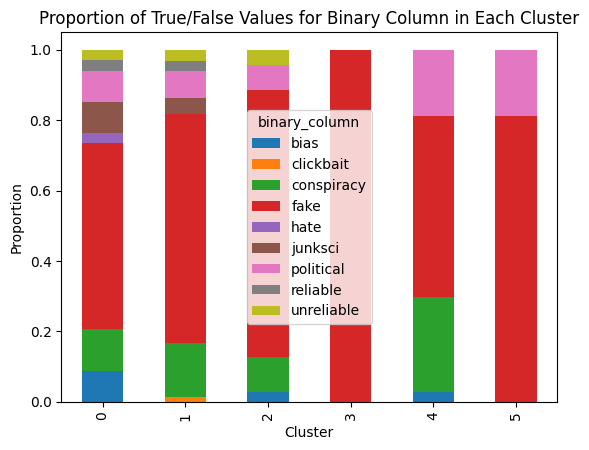

In [ ]:
# Create contingency table of true/false values for binary column in each cluster
df = pd.DataFrame({'cluster': kmeans.labels_, 'binary_column': data['type']})
contingency_table = pd.crosstab(df['cluster'], df['binary_column'], normalize='index')

# Plot stacked bar chart
contingency_table.plot(kind='bar', stacked=True)
plt.title('Proportion of True/False Values for Binary Column in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

In [ ]:
# Calculate distances from each data point to its nearest centroid
distances = np.min(cdist(tfidf.toarray(), kmeans.cluster_centers_, 'euclidean'), axis=1)

# Calculate the interquartile range and the upper and lower bounds for outlier detection
q1, q3 = np.percentile(distances, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 10.5 * iqr
upper_bound = q3 + 10.5 * iqr

# Identify the outliers
outliers = np.where((distances < lower_bound) | (distances > upper_bound))[0]

# Print the number of outliers and their indices
print(f"Number of outliers: {len(outliers)}")
print("Outlier indices: ", outliers)

# Print the content of the outlier articles
for idx in outliers:
    print(f"\nOutlier {idx}:\n{data['content'][idx]}")


Number of outliers: 9
Outlier indices:  [  1  38  42  50  94 130 170 180 190]

Outlier 1:
How To Easily Understand The Difference Between The Day Of Christ And The Day Of Lord In The End Times [0 3 2 4 1 0 2 0 4 2 2 2 2 4 1 2 4 0 4 2 1 2 1 1 1 5 2 2 1 1 1 2 1 0 2 4 4
 0 3 1 4 1 3 2 4 2 2 1 1 1 3 1 1 2 0 2 1 0 1 2 2 4 1 2 1 2 1 2 1 1 4 1 2 4
 2 4 2 1 2 2 0 2 0 1 1 1 1 1 4 5 1 0 2 1 3 5 1 5 1 2 2 2 0 5 5 2 0 4 2 1 1
 4 1 0 0 0 1 4 1 5 2 2 5 1 5 1 2 2 0 4 3 5 0 0 4 4 1 4 4 0 1 1 2 2 2 1 2 1
 4 1 5 2 1 2 2 2 4 0 1 4 1 4 2 1 1 1 0 5 1 1 3 1 4 2 2 4 1 4 2 2 3 1 4 5 4
 1 2 2 2 0 3 0 2 1 2 1 1 1 2 2 0 0 0 4 2 4 4 4 4 0 1 0 5 1 2 2 0 2 2 4 0 5
 0 0 2 5 2 2 2 2 2 0]

Outlier 38:
How To Easily Understand The Difference Between The Day Of Christ And The Day Of Lord In The End Times [0 3 2 4 1 0 2 0 4 2 2 2 2 4 1 2 4 0 4 2 1 2 1 1 1 5 2 2 1 1 1 2 1 0 2 4 4
 0 3 1 4 1 3 2 4 2 2 1 1 1 3 1 1 2 0 2 1 0 1 2 2 4 1 2 1 2 1 2 1 1 4 1 2 4
 2 4 2 1 2 2 0 2 0 1 1 1 1 1 4 5 1 0 2 1 3 5 1 5 1 2 2 2 0 5 5 2 0 4 